# Networks and their Structure Assignment

## Network Science Topics 2 and 4

Note that the networks in this exercise are undirected.

Recall the Watts-Strogatz network model from Topic 2.  Here we define a similar model which we call the **Variable Degree Watts-Strogatz (VDWS) model**.  This is how a **VDWS-network** is constructed.

* Let $n$ and $m$ be positive integers.  Let $p$ be a real number between 0 and 1.  Create a set of $n$ vertices labelled 0 to $n-1$.  We think of these as being arranged on a circle so if two adjacent vertices are close to each other on the circle, it is clear what is meant if we say that one is the clockwise neighbour of the other.  For example 4 is a clockwise neighbour of 2.
* For each $v$, let $\ell(v)$ be the local degree of $v$.  Choose the values $\ell(v)$ randomly such that they have a zero-truncated Poisson distribution with parameter $m$ (see below).  
* Join each vertex $v$ to vertices $v - \ell(v), v - \ell(v) + 1, \ldots, v-1, v+1, \ldots v + \ell(v) - 1, v + \ell(v)$ where addition is $\bmod n$.  Thus each vertex will have degree at least $2\ell(v)$, but it might be more.  For example, if 3 has local degree 2, then it will be adjacent to 1, 2, 4 and 5.   But if 10 has local degree 7, there will also be an edge between 3 and 10.   
* For each vertex $v$, for each edge from $v$ to a clockwise neighbour $w$: with probability $p$, the edge from $v$ to $w$ is deleted and replaced by an edge from $v$ to a vertex $x$ chosen uniformly at random from all the vertices in the network. We call this process *rewiring*. If $x=v$ or $x$ is already a neighbour of $v$, then we do nothing and the edge from $v$ to $w$ is kept.  (Note that in this way, each of the edges created in the previous step should be considered exactly once for rewiring, and that edges that are created by rewiring should not be later rewired themselves.)

You will need to write code to create VDWS-networks.  You can use the code for WS-networks (see Topic 4 on Learn Ultra) as a starting point.  To create values that are sampled from a zero-truncated Poisson distribution with parameter $m=10$, say, you can use the following code.

```python
import numpy as np
local_degrees = np.random.poisson(10, 100)
local_degrees = local_degrees[local_degrees > 0]
```

Note that the number of values created cannot be predicted precisely since the second line samples 100 values from a Poisson distribution and then the third line removes the zeros (although zeros are very unlikely for the value of $m$ we will use).

1. [20 marks] Consider the epidemic model with vaccinations from the Topic 4 lecture notes with states S, I, V, VI and R.  Using this model, simulate the spread of disease on a VDWS-network with $n=200000$, $m=25$ and $p=0.01$.  Assume that initially 5 randomly chosen vertices are in I and every other node is in S.  From $t=50$, at each time step move 400 randomly chosen vertices from S to V (until S is empty).  Let $t_I=2$ and consider various values for the other parameters.   Initially let $p(\mbox{I}, \mbox{S})=p(\mbox{I}, \mbox{V})=p(\mbox{VI}, \mbox{S})=p(\mbox{VI}, \mbox{V})=0.01$ (implying that the vaccination is ineffective).   Then consider cases where $p(\mbox{I}, \mbox{S})=0.01$ but the other probabilities are lower, modelling the cases where the vaccination protects against infection, transmission or both.  In each case, create plots that show  how the number of vertices in each of the five states varies over time.  Comment on your findings.

With the values given, each simulation should require no more than 400 time steps (before the infection dies out).  You should be able to run this in a few minutes on your own computer (or any university PC).  If you find that with the values I have given, the simulations take too long, then choose alternative values and document this in your submission.

In [77]:
from typing import Dict, Set, List, Literal, Callable, Optional
import numpy as np
import random
import matplotlib.pyplot as plt
import tqdm

Node = Vertex = int
Network = Graph = Dict[Node, Set[Node]]
NodeState = Literal["S", "I", "V", "VI", "R"]

In [43]:
def vdws_network(n_: int, m_: int, p_: float) -> Network:
    network_: Network = {i_: set() for i_ in range(n_)}

    local_degrees_: np.array = np.zeros(0)
    while len(local_degrees_) != n_:
        local_degrees_ = np.random.poisson(m_, n_)
        local_degrees_ = local_degrees_[local_degrees_ > 0]

    # Generate circular edges from local degrees
    for node_ in range(n_):
        local_degree_ = local_degrees_[node_]
        for neighbour_ in range(node_ - local_degree_, node_ + local_degree_ + 1):
            neighbour_ = neighbour_ % n_
            if node_ == neighbour_:
                continue

            network_[node_].add(neighbour_)
            network_[neighbour_].add(node_)

    # Rewire network
    for node_ in range(n_):
        local_degree_ = local_degrees_[node_]
        for clockwise_neighbour_ in range(node_ + 1, node_ + local_degree_ + 1):
            clockwise_neighbour_ = clockwise_neighbour_ % n_
            if random.random() < p_:
                new_neighbour_ = random.randint(0, n_ - 1)
                if new_neighbour_ != node_ and new_neighbour_ not in network_[node_]:
                    if clockwise_neighbour_ in network_[node_]:
                        network_[node_].remove(clockwise_neighbour_)
                    if node_ in network_[clockwise_neighbour_]:
                        network_[clockwise_neighbour_].remove(node_)

                    network_[node_].add(new_neighbour_)
                    network_[new_neighbour_].add(node_)

    return network_

In [44]:
vdws_network(10, 1, 0.5)

{0: {1, 2, 8},
 1: {0, 3, 4},
 2: {0, 3, 4, 7, 9},
 3: {1, 2, 4, 5},
 4: {1, 2, 3, 5, 9},
 5: {3, 4, 6, 9},
 6: {5, 7, 9},
 7: {2, 6, 8, 9},
 8: {0, 7},
 9: {2, 4, 5, 6, 7}}

In [80]:
def uniform_susceptible_sample(
        vaccinations_per_tick_: int,
        network_: Network,
        s_nodes_: Set[Node],
        i_nodes_: Set[Node],
        v_nodes_: Set[Node],
        vi_nodes_: Set[Node],
        r_nodes_: Set[Node]
) -> Set[Node]:
    return set(random.sample(s_nodes_, min(vaccinations_per_tick_, len(s_nodes_))))


def epidemic(
        network_: Network,
        p_i_s: float,
        p_i_v: float,
        p_vi_s: float,
        p_vi_v: float,
        vaccinations_per_tick: int = 400,
        ti: int = 2,
        max_ticks: int = 400,
        vaccination_function: Callable[
            [int, Network, Set[Node], Set[Node], Set[Node], Set[Node], Set[Node]],
            Set[Node]
        ] = uniform_susceptible_sample
) -> None:
    n_ = len(network_)
    node_states_: List[NodeState] = ["S"] * n_
    s_nodes_: Set[Node] = set(network_)
    i_nodes_: Dict[Node, int] = {}
    v_nodes_: Set[Node] = set()
    vi_nodes_: Dict[Node, int] = {}
    r_nodes_: Set[Node] = set()

    t_values_: List[int] = []
    s_counts_: List[int] = []
    i_counts_: List[int] = []
    v_counts_: List[int] = []
    vi_counts_: List[int] = []
    r_counts_: List[int] = []

    # Initial infection
    for i_node_ in random.sample(list(network_), 5):
        s_nodes_.remove(i_node_)
        node_states_[i_node_] = "I"
        i_nodes_[i_node_] = ti

    # Main simulation loop
    t_ = 0
    progress_ = tqdm.tqdm(total=max_ticks)
    while t_ < max_ticks and len(r_nodes_) < len(network_):
        # Simulate all the infected nodes
        for i_node_ in set(i_nodes_):
            # Simulate neighbour infection
            for neighbour_ in network_[i_node_]:
                # Simulate infection if susceptible
                if node_states_[neighbour_] == "S" and random.random() <= p_i_s:
                    s_nodes_.remove(neighbour_)
                    i_nodes_[neighbour_] = ti
                    node_states_[neighbour_] = "I"

                # Simulate infection if vaccinated
                if node_states_[neighbour_] == "V" and random.random() <= p_i_v:
                    v_nodes_.remove(neighbour_)
                    vi_nodes_[neighbour_] = ti
                    node_states_[neighbour_] = "VI"

            i_nodes_[i_node_] -= 1
            # Remove those who have been infected for ti ticks
            if i_nodes_[i_node_] < 0:
                i_nodes_.pop(i_node_)
                r_nodes_.add(i_node_)
                node_states_[i_node_] = "R"

        # Simulate all the infected vaccinated nodes
        for vi_node_ in set(vi_nodes_):
            # Simulate neighbour infection
            for neighbour_ in network_[vi_node_]:
                # Simulate infection if susceptible
                if node_states_[neighbour_] == "S" and random.random() <= p_vi_s:
                    s_nodes_.remove(neighbour_)
                    i_nodes_[neighbour_] = ti
                    node_states_[neighbour_] = "I"

                # Simulate infection if vaccinated
                if node_states_[neighbour_] == "V" and random.random() <= p_vi_v:
                    v_nodes_.remove(neighbour_)
                    vi_nodes_[neighbour_] = ti
                    node_states_[neighbour_] = "VI"

            vi_nodes_[vi_node_] -= 1
            # Remove those who have been infected for ti ticks
            if vi_nodes_[vi_node_] < 0:
                vi_nodes_.pop(vi_node_)
                r_nodes_.add(vi_node_)
                node_states_[vi_node_] = "R"

        # Vaccination uptake simulation
        if t_ > 49:
            for v_node_ in vaccination_function(
                vaccinations_per_tick,
                network_,
                s_nodes_,
                set(i_nodes_),
                v_nodes_,
                set(vi_nodes_),
                r_nodes_
            ):
                s_nodes_.remove(v_node_)
                v_nodes_.add(v_node_)
                node_states_[v_node_] = "V"

        t_values_.append(t_)
        s_counts_.append(len(s_nodes_))
        i_counts_.append(len(i_nodes_))
        v_counts_.append(len(v_nodes_))
        vi_counts_.append(len(vi_nodes_))
        r_counts_.append(len(r_nodes_))

        t_ += 1
        progress_.update()

    plt.plot(t_values_, s_counts_, label="S")
    plt.plot(t_values_, i_counts_, label="I")
    plt.plot(t_values_, v_counts_, label="V")
    plt.plot(t_values_, vi_counts_, label="VI")
    plt.plot(t_values_, r_counts_, label="R")
    plt.xlabel("Time Steps")
    plt.ylabel("Number of Nodes by State")
    plt.legend()
    plt.show()


In [54]:
network = vdws_network(200000, 25, 0.01)

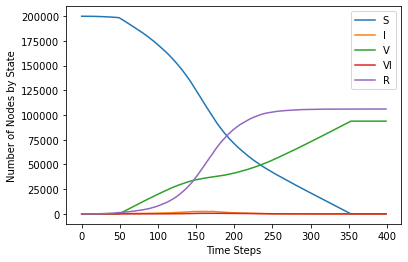

In [55]:
# All probabilities equal (vaccines are no more effective)
epidemic(
    network,
    0.01,
    0.01,
    0.01,
    0.01,
    400,
    2,
    400
)

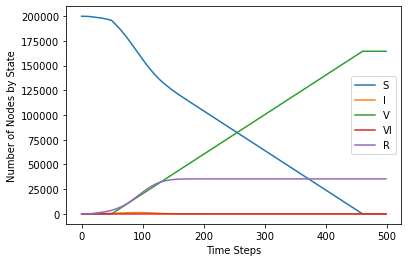

In [56]:
# Vaccines protect against infection, but not transmission
epidemic(
    network,
    0.01,
    0.0001,
    0.01,
    0.01,
    400,
    2
)

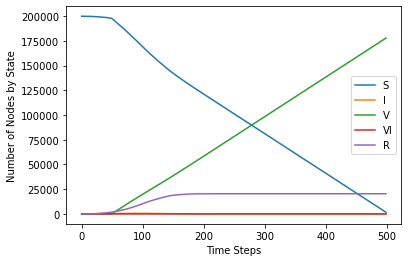

In [62]:
# Vaccines protect against transmission, but not infection
epidemic(
    network,
    0.01,
    0.01,
    0.0001,
    0.0001,
    400,
    2
)

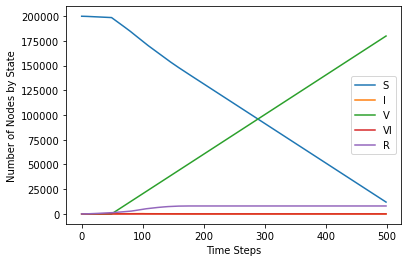

In [63]:
# Vaccines protect against transmission and infection
epidemic(
    network,
    0.01,
    0.0001,
    0.0001,
    0.0001,
    400,
    2
)

## Findings

When vaccines are not effective, as expected, there is a clear spike in cases both infected unvaccinated nodes (and slightly delayed in) and infected vaccinated nodes.
For vaccines protecting against infection, but not transmission, there is a much lower spike (demonstrated by the lower resultant number of R nodes).
For vaccines protecting against transmission, but not infection, the peak number of R nodes is lower yet again, and, again unsurprisingly, combining both transmission and infection protection, there is a very low resulting number of R nodes, and hence, a much lower spike in cases overall.

2. [25 marks] Repeat the simulations of the previous question, but with the single change that the 400 vertices moved from S to V at each time step (after $t=50$) can be strategically chosen (rather than being chosen at random).  Propose and test three different strategies and comment on their effectiveness.


## Strategy 1

Vaccinate the first susceptible neighbour, of those who are infected (chosen at random).

In [71]:
def uniform_infected_neighbour_strategy(
        vaccinations_per_tick_: int,
        network_: Network,
        s_nodes_: Set[Node],
        i_nodes_: Set[Node],
        v_nodes_: Set[Node],
        vi_nodes_: Set[Node],
        r_nodes_: Set[Node]
) -> Set[Node]:
    sampled_infected_: Set[Node] = set(random.sample(i_nodes_, min(vaccinations_per_tick_, len(i_nodes_))))
    to_vaccinate_: Set[Node] = set()
    for infected_ in sampled_infected_:
        if not s_nodes_:
            return to_vaccinate_
        # Default to a random susceptible node (to be used if no susceptible neighbour is found)
        neighbor_to_vaccinate_ = random.sample(s_nodes_, 1)[0]
        for neighbor_ in network_[infected_]:
            if neighbor_ in s_nodes_:
                neighbor_to_vaccinate_ = neighbor_
                break
        to_vaccinate_.add(neighbor_to_vaccinate_)
    return to_vaccinate_

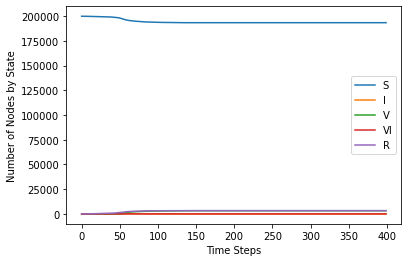

In [72]:
# Vaccines protect against infection, but not transmission
epidemic(
    network,
    0.01,
    0.0001,
    0.01,
    0.01,
    400,
    2,
    400,
    uniform_infected_neighbour_strategy
)

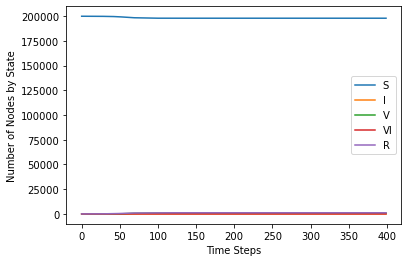

In [73]:
# Vaccines protect against transmission, but not infection
epidemic(
    network,
    0.01,
    0.01,
    0.0001,
    0.0001,
    400,
    2,
    400,
    uniform_infected_neighbour_strategy
)


 36%|███▋      | 146/400 [00:16<00:06, 37.11it/s]

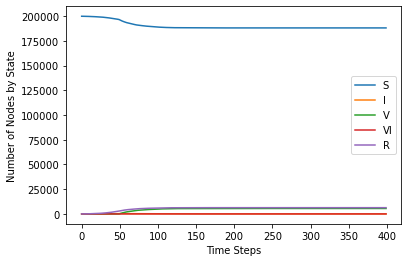

In [82]:
# Vaccines protect against transmission and infection
epidemic(
    network,
    0.01,
    0.0001,
    0.0001,
    0.0001,
    400,
    2,
    400,
    uniform_infected_neighbour_strategy
)

The results from the first strategy show that this was a very effective way of preventing infection.
Additionally, it demonstrates that this strategy is more effective when vaccines protect against infection (not as much when protecting against transmission, but still good results).

## Strategy 2

Vaccinate as many susceptible neighbours of those infected as possible, then move onto the next neighbour.

In [75]:
def first_infected_neighbour_strategy(
        vaccinations_per_tick_: int,
        network_: Network,
        s_nodes_: Set[Node],
        i_nodes_: Set[Node],
        v_nodes_: Set[Node],
        vi_nodes_: Set[Node],
        r_nodes_: Set[Node]
) -> Set[Node]:
    to_vaccinate_: Set[Node] = set()
    while len(to_vaccinate_) < vaccinations_per_tick_:
        if not i_nodes_:
            # If there are no infected left, vaccinate randomly sampled nodes
            to_vaccinate_.update(
                set(random.sample(
                    s_nodes_,
                    min(vaccinations_per_tick_ - len(to_vaccinate_), len(s_nodes_))
                ))
            )
            return to_vaccinate_

        # Select random infected
        infected_ = random.sample(i_nodes_, 1)[0]
        for neighbour_ in network_[infected_]:
            if neighbour_ in s_nodes_:
                to_vaccinate_.add(neighbour_)

                if len(to_vaccinate_) == vaccinations_per_tick_:
                    return to_vaccinate_
    return to_vaccinate_

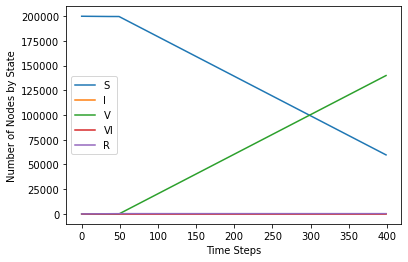

In [78]:
# Vaccines protect against infection, but not transmission
epidemic(
    network,
    0.01,
    0.0001,
    0.01,
    0.01,
    400,
    2,
    400,
    first_infected_neighbour_strategy
)

In [84]:
# Vaccines protect against transmission and infection
epidemic(
    network,
    0.01,
    0.0001,
    0.0001,
    0.0001,
    400,
    2,
    400,
    first_infected_neighbour_strategy
)




  0%|          | 0/400 [00:00<?, ?it/s]

KeyboardInterrupt: 

Strategy 2 was still effective but not quite as impressive as Strategy 1 (and took significantly longer to simulate).
It did a better job of vaccinating people while keeping infection rates to a minimum.

## Strategy 3

The final strategy is to vaccinate neighbours of those already vaccinated, this is the same as Strategy 1 except vaccinated nodes are sampled from (instead of those infected).

In [85]:
def vaccinated_neighbour_strategy(
        vaccinations_per_tick_: int,
        network_: Network,
        s_nodes_: Set[Node],
        i_nodes_: Set[Node],
        v_nodes_: Set[Node],
        vi_nodes_: Set[Node],
        r_nodes_: Set[Node]
) -> Set[Node]:
    sampled_vaccinated_: Set[Node] = set(random.sample(v_nodes_, min(vaccinations_per_tick_, len(v_nodes_))))
    to_vaccinate_: Set[Node] = set()
    for vaccinated_ in sampled_vaccinated_:
        if not s_nodes_:
            return to_vaccinate_
        # Default to a random susceptible node (to be used if no susceptible neighbour is found)
        neighbor_to_vaccinate_ = random.sample(s_nodes_, 1)[0]
        for neighbor_ in network_[vaccinated_]:
            if neighbor_ in s_nodes_:
                neighbor_to_vaccinate_ = neighbor_
                break
        to_vaccinate_.add(neighbor_to_vaccinate_)
    return to_vaccinate_





  0%|          | 0/400 [00:00<?, ?it/s]



 19%|█▉        | 77/400 [00:00<00:00, 754.91it/s]



 25%|██▌       | 101/400 [00:00<00:00, 448.98it/s]



 31%|███       | 124/400 [00:00<00:01, 273.29it/s]



 36%|███▋      | 145/400 [00:00<00:01, 148.53it/s]



 40%|████      | 162/400 [00:01<00:02, 89.51it/s] 



 44%|████▍     | 175/400 [00:01<00:03, 62.09it/s]



 46%|████▋     | 186/400 [00:01<00:04, 50.20it/s]



 49%|████▉     | 195/400 [00:01<00:04, 44.49it/s]



 50%|█████     | 202/400 [00:02<00:04, 42.11it/s]



 52%|█████▏    | 208/400 [00:02<00:04, 43.15it/s]



 54%|█████▎    | 214/400 [00:02<00:04, 45.10it/s]



 55%|█████▌    | 220/400 [00:02<00:03, 47.46it/s]



 57%|█████▋    | 227/400 [00:02<00:03, 51.27it/s]



 59%|█████▉    | 235/400 [00:02<00:02, 57.33it/s]



 61%|██████    | 244/400 [00:02<00:02, 64.06it/s]



 64%|██████▍   | 258/400 [00:02<00:01, 76.51it/s]



 15%|█▌        | 60/400 [08:35<48:43,  8.60s/it] ]


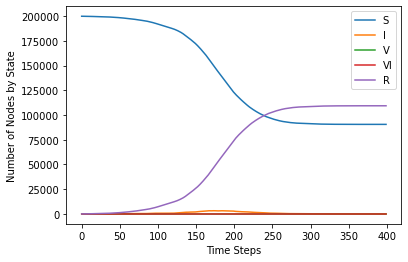

In [86]:
# Vaccines protect against infection, but not transmission
epidemic(
    network,
    0.01,
    0.0001,
    0.01,
    0.01,
    400,
    2,
    400,
    vaccinated_neighbour_strategy
)



  0%|          | 0/400 [00:00<?, ?it/s]

 16%|█▋        | 66/400 [00:00<00:00, 634.63it/s]

 22%|██▏       | 86/400 [00:00<00:00, 369.28it/s]

 26%|██▋       | 105/400 [00:00<00:01, 247.34it/s]

 31%|███       | 123/400 [00:00<00:01, 141.57it/s]

 34%|███▍      | 138/400 [00:00<00:03, 78.96it/s] 

 38%|███▊      | 150/400 [00:01<00:04, 55.90it/s]

 40%|███▉      | 159/400 [00:01<00:05, 43.56it/s]

 42%|████▏     | 167/400 [00:01<00:05, 39.07it/s]

 43%|████▎     | 173/400 [00:02<00:06, 37.22it/s]

 45%|████▍     | 179/400 [00:02<00:06, 36.76it/s]

 46%|████▌     | 184/400 [00:02<00:05, 36.44it/s]

 47%|████▋     | 189/400 [00:02<00:05, 36.70it/s]

 48%|████▊     | 194/400 [00:02<00:05, 38.77it/s]

 50%|████▉     | 199/400 [00:02<00:04, 41.16it/s]

 51%|█████▏    | 205/400 [00:02<00:04, 44.53it/s]

 53%|█████▎    | 212/400 [00:02<00:03, 49.25it/s]

 56%|█████▌    | 222/400 [00:03<00:03, 57.69it/s]

 59%|█████▉    | 237/400 [00:03<00:02, 70.55it/s]

 66%|██████▋   | 265/400 [00:03<00:0

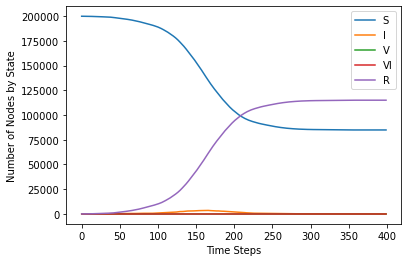

In [87]:
# Vaccines protect against transmission, but not infection
epidemic(
    network,
    0.01,
    0.01,
    0.0001,
    0.0001,
    400,
    2,
    400,
    vaccinated_neighbour_strategy
)






  0%|          | 0/400 [00:00<?, ?it/s]




 18%|█▊        | 70/400 [00:00<00:00, 679.62it/s]




 23%|██▎       | 91/400 [00:00<00:00, 374.14it/s]




 28%|██▊       | 111/400 [00:00<00:01, 213.18it/s]




 32%|███▏      | 129/400 [00:00<00:02, 125.52it/s]




 36%|███▌      | 143/400 [00:01<00:03, 77.36it/s] 




 38%|███▊      | 154/400 [00:01<00:04, 55.66it/s]




 41%|████      | 163/400 [00:01<00:05, 45.71it/s]




 43%|████▎     | 171/400 [00:01<00:05, 42.44it/s]




 44%|████▍     | 178/400 [00:02<00:05, 41.31it/s]




 46%|████▌     | 184/400 [00:02<00:05, 40.66it/s]




 47%|████▋     | 189/400 [00:02<00:05, 40.95it/s]




 48%|████▊     | 194/400 [00:02<00:04, 42.10it/s]




 50%|█████     | 200/400 [00:02<00:04, 45.19it/s]




 52%|█████▏    | 206/400 [00:02<00:04, 48.10it/s]




 54%|█████▎    | 214/400 [00:02<00:03, 53.54it/s]




 56%|█████▌    | 223/400 [00:02<00:02, 60.83it/s]




 58%|█████▊    | 234/400 [00:02<00:02, 69.45it/s]




 62%|██████▎   | 250/400 [00:0

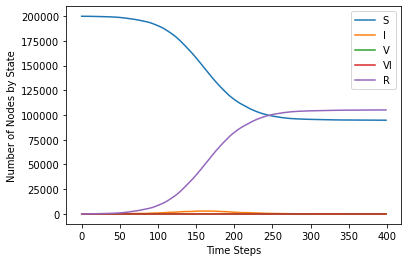

In [88]:
# Vaccines protect against transmission and infection
epidemic(
    network,
    0.01,
    0.0001,
    0.0001,
    0.0001,
    400,
    2,
    400,
    vaccinated_neighbour_strategy
)

Strategy 3 shows an interesting trend, there is a clear spike in the number of cases however it is still an effective means of targeted vaccination, this is almost a simulation of heard immunity.